In [ ]:
# Exploration of Vanishing Gradients and its solutions
# Copyright (C) 2019  Abien Fred Agarap, Joshua Cruzada
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

Towards Understanding of the Vanishing Gradients Problem and its solutions
===

## Overview

We explore the performance of a neural network with different activation functions.

## Setup

We import libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap, Joshua Raphaelle Cruzada'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utils import create_dataset
assert tf.__version__.startswith('2')

Set up seeds for reproducibility.

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Allocate GPU memory as needed.

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Dataset 

We use synthetic dataset for training and testing deep neural nets.

In [4]:
batch_size = 256
epochs = 600

We use blobs, circles, and moons synthetic datasets.

In [5]:
blobs_training_dataset, blobs_test_dataset = create_dataset(batch_size=batch_size, data='blobs', onehot=True)
circles_training_dataset, circles_test_dataset = create_dataset(batch_size=batch_size, data='circles', onehot=True)
moons_training_dataset, moons_test_dataset = create_dataset(batch_size=batch_size, data='moons', onehot=True)

W0608 15:16:12.309862 140200299308800 deprecation.py:323] From /home/abien_senti/venv2/lib/python3.5/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We visualize the generated datasets.

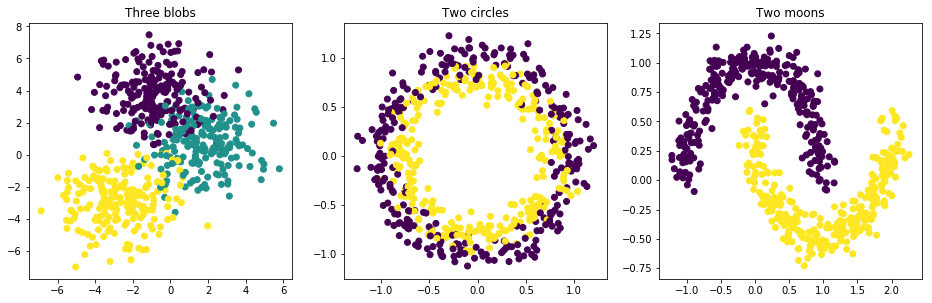

In [6]:
plt.figure(figsize=(16, 16))

plt.subplot(331)
plt.title('Three blobs')
plt.scatter(blobs_test_dataset[0][:, 0], blobs_test_dataset[0][:, 1], c=np.argmax(blobs_test_dataset[1], 1))

plt.subplot(332)
plt.title('Two circles')
plt.scatter(circles_test_dataset[0][:, 0], circles_test_dataset[0][:, 1], c=np.argmax(circles_test_dataset[1], 1))

plt.subplot(333)
plt.title('Two moons')
plt.scatter(moons_test_dataset[0][:, 0], moons_test_dataset[0][:, 1], c=np.argmax(moons_test_dataset[1], 1))

plt.show()

## Deep Neural Network

In this notebook, we write a deep neural network using the TensorFlow Subclassing API.

In [7]:
class NeuralNet(tf.keras.Model):
    def __init__(self, units, activation, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=units, activation=activation, use_bias=False)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=units, activation=activation, use_bias=False)
        self.hidden_layer_3 = tf.keras.layers.Dense(units=units, activation=activation, use_bias=False)
        self.hidden_layer_4 = tf.keras.layers.Dense(units=units, activation=activation, use_bias=False)
        self.hidden_layer_5 = tf.keras.layers.Dense(units=units, activation=activation, use_bias=False)
        self.output_layer = tf.keras.layers.Dense(units=num_classes, use_bias=False)
        self.optimizer = tf.optimizers.SGD(learning_rate=1e-1, momentum=9e-1)
    
    @tf.function
    def call(self, input_features):
        activations = self.hidden_layer_1(input_features)
        activations = self.hidden_layer_2(activations)
        activations = self.hidden_layer_3(activations)
        activations = self.hidden_layer_4(activations)
        activations = self.hidden_layer_5(activations)
        output = self.output_layer(activations)
        return output

We define the loss function for the model. For general applicability across the synthetic datasets, we shall use the softmax cross entropy function.

In [8]:
def loss_fn(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

We define the train step for the model.

In [9]:
def train_step(model, loss, batch_features, batch_labels):
    with tf.GradientTape() as tape:
        logits = model(batch_features)
        train_loss = loss(logits=logits, labels=batch_labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss, gradients

We define a recorder of gradients for TensorBoard.

In [10]:
def plot_gradients(gradients, step):
    for index, gradient in enumerate(gradients):
        tf.summary.histogram('histogram/{}'.format(index), gradient, step)

We define the training loop.

In [11]:
def train(model, loss_fn, dataset, epochs=10):
    
    writer = tf.summary.create_file_writer('tmp/{}'.format(time.asctime()))    
    
    with writer.as_default():
        with tf.summary.record_if(True):
            step = 0
            for epoch in range(epochs):
                epoch_loss = 0
                epoch_accuracy = []
                for batch_features, batch_labels in dataset:
                    
                    batch_loss, train_gradients = train_step(model, loss_fn, batch_features, batch_labels)
                    
                    accuracy = tf.metrics.Accuracy()
                    accuracy(tf.argmax(model(batch_features), 1), tf.argmax(batch_labels, 1))

                    epoch_loss += batch_loss
                    epoch_accuracy.append(accuracy.result())
                    plot_gradients(train_gradients, step)
                    
                    step += 1
                    
                epoch_loss = tf.reduce_mean(epoch_loss)
                epoch_accuracy = tf.reduce_mean(epoch_accuracy)
                
                tf.summary.scalar('loss', epoch_loss, step=step)
                tf.summary.scalar('accuracy', epoch_accuracy, step=step)

                if epoch != 0 and (epoch + 1) % 100 == 0:
                    print('Epoch {}/{}. Loss : {}, Accuracy : {}'.format(epoch + 1, epochs, epoch_loss, epoch_accuracy))

## Varying Activation Functions 

We vary the activation functions used for a deep neural network with 5 layers having 8 neurons each.

### Sigmoid

The sigmoid or logistic activation function is similar to the hyperbolic tangent, with the difference being its range of values is in $[0, 1] \in \mathbb{R}$.

$$ \sigma(x) = \dfrac{1}{1 + e^{-x}} $$

#### Blobs Dataset

We instantiate a neural net class with `sigmoid` activation function.

In [12]:
model = NeuralNet(units=8, activation=tf.nn.sigmoid, num_classes=blobs_test_dataset[1].shape[1])

We train the 5-layer neural net with `sigmoid` activation.

In [13]:
start_time = time.time()
train(model, loss_fn, blobs_training_dataset, epochs)
print('training time : {}'.format(time.time() - start_time))

Epoch 100/600. Loss : 2.652895927429199, Accuracy : 0.706250011920929
Epoch 200/600. Loss : 1.2421894073486328, Accuracy : 0.9125000238418579
Epoch 300/600. Loss : 1.1999001502990723, Accuracy : 0.913281261920929
Epoch 400/600. Loss : 1.1656876802444458, Accuracy : 0.917187511920929
Epoch 500/600. Loss : 1.0332658290863037, Accuracy : 0.918749988079071
Epoch 600/600. Loss : 0.9555231332778931, Accuracy : 0.9195312261581421
training time : 187.94901943206787


We measure the classification performance of the neural net. First, we set up the metrics.

In [14]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [15]:
blobs_sigmoid_predictions = tf.nn.softmax(model(blobs_test_dataset[0]))

Lastly, we compute the classification performance.

In [16]:
test_accuracy = accuracy(np.argmax(blobs_sigmoid_predictions, 1), np.argmax(blobs_test_dataset[1], 1))
test_precision = precision(blobs_sigmoid_predictions, blobs_test_dataset[1])
test_recall = recall(blobs_sigmoid_predictions, blobs_test_dataset[1])
test_auc = auc(blobs_sigmoid_predictions, blobs_test_dataset[1])

Display the performance measures.

In [17]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

Accuracy : 0.9133333563804626
Precision : 1.0
Recall : 0.3333333432674408
AUC : 0.0


#### Circles Dataset

We instantiate a neural net class with `sigmoid` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.sigmoid, num_classes=circles_test_dataset[1].shape[1])

We train the 5-layer neural net with `sigmoid` activation.

In [ ]:
start_time = time.time()
train(model, loss_fn, circles_training_dataset, epochs)
print('training time : {}'.format(time.time() - start_time))

Re-instantiate metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
circles_sigmoid_predictions = tf.nn.softmax(model(circles_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(circles_sigmoid_predictions, 1), np.argmax(circles_test_dataset[1], 1))
test_precision = precision(circles_sigmoid_predictions, circles_test_dataset[1])
test_recall = recall(circles_sigmoid_predictions, circles_test_dataset[1])
test_auc = auc(circles_sigmoid_predictions, circles_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

#### Moons Dataset

We instantiate a neural net class with `sigmoid` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.sigmoid, num_classes=moons_test_dataset[1].shape[1])

We train the 5-layer neural net with `sigmoid` activation.

In [ ]:
train(model, loss_fn, moons_training_dataset, epochs)

Re-instantiate metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
moons_sigmoid_predictions = tf.nn.softmax(model(moons_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(moons_sigmoid_predictions, 1), np.argmax(moons_test_dataset[1], 1))
test_precision = precision(moons_sigmoid_predictions, moons_test_dataset[1])
test_recall = recall(moons_sigmoid_predictions, moons_test_dataset[1])
test_auc = auc(moons_sigmoid_predictions, moons_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

### Hyperbolic Tangent

We use the hyperbolic tangent activation function.

$$ tanh(x) = \dfrac{e^x - e^{-x}}{e^x + e^{-x}} $$

#### Blobs Dataset 

We instantiate a neural net class with `tanh` activation function.

In [18]:
model = NeuralNet(units=8, activation=tf.nn.tanh, num_classes=blobs_test_dataset[1].shape[1])

We train the 5-layer neural net with `tanh` activation.

In [19]:
start_time = time.time()
train(model, loss_fn, blobs_training_dataset, epochs)
print('training time : {}'.format(time.time() - start_time))

Epoch 100/600. Loss : 0.8906395435333252, Accuracy : 0.922656238079071
Epoch 200/600. Loss : 0.849082350730896, Accuracy : 0.9281250238418579
Epoch 300/600. Loss : 0.8067702054977417, Accuracy : 0.9273437261581421
Epoch 400/600. Loss : 0.8531668186187744, Accuracy : 0.92578125
Epoch 500/600. Loss : 0.754823625087738, Accuracy : 0.9312499761581421
Epoch 600/600. Loss : 0.735640287399292, Accuracy : 0.9359375238418579
training time : 188.0977964401245


We measure the classification performance of the neural net.

In [20]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get the test predictions.

In [21]:
blobs_tanh_predictions = tf.nn.softmax(model(blobs_test_dataset[0]))

Lastly, we compute the classification performance.

In [22]:
test_accuracy = accuracy(np.argmax(blobs_tanh_predictions, 1), np.argmax(blobs_test_dataset[1], 1))
test_precision = precision(blobs_tanh_predictions, blobs_test_dataset[1])
test_recall = recall(blobs_tanh_predictions, blobs_test_dataset[1])
test_auc = auc(blobs_tanh_predictions, blobs_test_dataset[1])

Display the performance measures.

In [23]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

Accuracy : 0.9133333563804626
Precision : 1.0
Recall : 0.3333333432674408
AUC : 0.0


#### Circles Dataset 

We instantiate a neural net class with `tanh` activation function.

In [30]:
model = NeuralNet(units=8, activation=tf.nn.tanh, num_classes=circles_test_dataset[1].shape[1])

We train the 5-layer neural net with `tanh` activation.

In [31]:
train(model, loss_fn, circles_training_dataset, epochs)

Epoch 100/600. Loss : 1.806210994720459, Accuracy : 0.8374999761581421
Epoch 200/600. Loss : 1.6617588996887207, Accuracy : 0.84375
Epoch 300/600. Loss : 1.6255152225494385, Accuracy : 0.8453124761581421
Epoch 400/600. Loss : 1.5971457958221436, Accuracy : 0.8500000238418579
Epoch 500/600. Loss : 1.580018401145935, Accuracy : 0.8578125238418579
Epoch 600/600. Loss : 1.5498874187469482, Accuracy : 0.856249988079071


After training, we get the test predictions.

In [32]:
circles_tanh_predictions = tf.nn.softmax(model(circles_test_dataset[0]))

Re-instantiate metrics.

In [33]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Lastly, we compute the classification performance.

In [34]:
test_accuracy = accuracy(np.argmax(circles_tanh_predictions, 1), np.argmax(circles_test_dataset[1], 1))
test_precision = precision(circles_tanh_predictions, circles_test_dataset[1])
test_recall = recall(circles_tanh_predictions, circles_test_dataset[1])
test_auc = auc(circles_tanh_predictions, circles_test_dataset[1])

Display the performance measures.

In [35]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

Accuracy : 0.8349999785423279
Precision : 1.0
Recall : 0.5
AUC : 0.0


#### Moons Dataset 

We instantiate a neural net class with `tanh` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.tanh, num_classes=moons_test_dataset[1].shape[1])

We train the 5-layer neural net with `tanh` activation.

In [ ]:
train(model, loss_fn, moons_training_dataset, epochs)

After training, we get the test predictions.

In [ ]:
moons_tanh_predictions = tf.nn.softmax(model(moons_test_dataset[0]))

Re-instantiate metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(moons_tanh_predictions, 1), np.argmax(moons_test_dataset[1], 1))
test_precision = precision(moons_tanh_predictions, moons_test_dataset[1])
test_recall = recall(moons_tanh_predictions, moons_test_dataset[1])
test_auc = auc(moons_tanh_predictions, moons_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

### Rectified Linear Units

The ReLU function became a popular activation function as it solves the vanishing gradients problem by thresholding activations to 0 if they are less than or equal to 0.

$$ relu(x) = \max(0, x) $$

#### Blobs Dataset

We instantiate a neural net class with `relu` activation function.

In [24]:
model = NeuralNet(units=8, activation=tf.nn.relu, num_classes=blobs_test_dataset[1].shape[1])

We train the 5-layer neural net with `relu` activation.

In [25]:
start_time = time.time()
train(model, loss_fn, blobs_training_dataset, epochs)
print('training time : {}'.format(time.time() - start_time))

Epoch 100/600. Loss : 1.389090895652771, Accuracy : 0.905468761920929
Epoch 200/600. Loss : 1.3537657260894775, Accuracy : 0.9078124761581421
Epoch 300/600. Loss : 1.3163936138153076, Accuracy : 0.907031238079071
Epoch 400/600. Loss : 1.2892158031463623, Accuracy : 0.905468761920929
Epoch 500/600. Loss : 1.281981110572815, Accuracy : 0.9085937738418579
Epoch 600/600. Loss : 0.9678728580474854, Accuracy : 0.9164062738418579
training time : 189.8317370414734


We measure the classification performance of the neural net. First, we set up the metrics.

In [26]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [27]:
blobs_relu_predictions = tf.nn.softmax(model(blobs_test_dataset[0]))

Lastly, we compute the classification performance.

In [28]:
test_accuracy = accuracy(np.argmax(blobs_relu_predictions, 1), np.argmax(blobs_test_dataset[1], 1))
test_precision = precision(blobs_relu_predictions, blobs_test_dataset[1])
test_recall = recall(blobs_relu_predictions, blobs_test_dataset[1])
test_auc = auc(blobs_relu_predictions, blobs_test_dataset[1])

Display the performance measures.

In [29]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

Accuracy : 0.9083333611488342
Precision : 1.0
Recall : 0.3333333432674408
AUC : 0.0


#### Circles Dataset

We instantiate a neural net class with `relu` activation function.

In [36]:
model = NeuralNet(units=8, activation=tf.nn.relu, num_classes=circles_test_dataset[1].shape[1])

We train the 5-layer neural net with `relu` activation.

In [37]:
train(model, loss_fn, circles_training_dataset, epochs)

Epoch 100/600. Loss : 1.6774605512619019, Accuracy : 0.8539062738418579
Epoch 200/600. Loss : 1.6999400854110718, Accuracy : 0.840624988079071
Epoch 300/600. Loss : 1.6383154392242432, Accuracy : 0.848437488079071
Epoch 400/600. Loss : 1.6354645490646362, Accuracy : 0.8531249761581421
Epoch 500/600. Loss : 1.569920301437378, Accuracy : 0.8648437261581421
Epoch 600/600. Loss : 1.6332045793533325, Accuracy : 0.8515625


We measure the classification performance of the neural net. First, we set up the metrics.

In [38]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [39]:
circles_relu_predictions = tf.nn.softmax(model(circles_test_dataset[0]))

Lastly, we compute the classification performance.

In [40]:
test_accuracy = accuracy(np.argmax(circles_relu_predictions, 1), np.argmax(circles_test_dataset[1], 1))
test_precision = precision(circles_relu_predictions, circles_test_dataset[1])
test_recall = recall(circles_relu_predictions, circles_test_dataset[1])
test_auc = auc(circles_relu_predictions, circles_test_dataset[1])

Display the performance measures.

In [41]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

Accuracy : 0.8333333134651184
Precision : 1.0
Recall : 0.5
AUC : 0.0


#### Moons Dataset

We instantiate a neural net class with `relu` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.relu, num_classes=moons_test_dataset[1].shape[1])

We train the 5-layer neural net with `relu` activation.

In [ ]:
train(model, loss_fn, moons_training_dataset, epochs)

We measure the classification performance of the neural net. First, we set up the metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
moons_relu_predictions = tf.nn.softmax(model(moons_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(moons_relu_predictions, 1), np.argmax(moons_test_dataset[1], 1))
test_precision = precision(moons_relu_predictions, moons_test_dataset[1])
test_recall = recall(moons_relu_predictions, moons_test_dataset[1])
test_auc = auc(moons_relu_predictions, moons_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

### Leaky ReLU

Although ReLU solves the vanishing gradients problem, it does not account for the "dead ReLU" problem, i.e. when activations become zero. Instead, we squash activations to their fraction instead of squashing them directly to 0.

$$ l\_relu(x) = \max(0.02x, x) $$

#### Blobs Dataset

We instantiate a neural net class with `leaky_relu` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.leaky_relu, num_classes=blobs_test_dataset[1].shape[1])

We train the 5-layer neural net with `leaky_relu` activation.

In [ ]:
train(model, loss_fn, blobs_training_dataset, epochs)

We measure the classification performance of the neural net. First, we set up the metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
blobs_lrelu_predictions = tf.nn.softmax(model(blobs_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(blobs_lrelu_predictions, 1), np.argmax(blobs_test_dataset[1], 1))
test_precision = precision(blobs_lrelu_predictions, blobs_test_dataset[1])
test_recall = recall(blobs_lrelu_predictions, blobs_test_dataset[1])
test_auc = auc(blobs_lrelu_predictions, blobs_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

#### Circles Dataset

We instantiate a neural net class with `leaky_relu` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.leaky_relu, num_classes=circles_test_dataset[1].shape[1])

We train the 5-layer neural net with `leaky_relu` activation.

In [ ]:
train(model, loss_fn, circles_training_dataset, epochs)

We measure the classification performance of the neural net. First, we set up the metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
circles_lrelu_predictions = tf.nn.softmax(model(circles_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(circles_lrelu_predictions, 1), np.argmax(circles_test_dataset[1], 1))
test_precision = precision(circles_lrelu_predictions, circles_test_dataset[1])
test_recall = recall(circles_lrelu_predictions, circles_test_dataset[1])
test_auc = auc(circles_lrelu_predictions, circles_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

#### Moons Dataset

We instantiate a neural net class with `leaky_relu` activation function.

In [ ]:
model = NeuralNet(units=8, activation=tf.nn.leaky_relu, num_classes=moons_test_dataset[1].shape[1])

We train the 5-layer neural net with `leaky_relu` activation.

In [ ]:
train(model, loss_fn, moons_training_dataset, epochs)

We measure the classification performance of the neural net.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
moons_lrelu_predictions = tf.nn.softmax(model(moons_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(moons_lrelu_predictions, 1), np.argmax(moons_test_dataset[1], 1))
test_precision = precision(moons_lrelu_predictions, moons_test_dataset[1])
test_recall = recall(moons_lrelu_predictions, moons_test_dataset[1])
test_auc = auc(moons_lrelu_predictions, moons_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

### Swish

$$ f(x) = x * \sigma(x) $$

In [ ]:
def swish(x):
    return x * tf.nn.sigmoid(x)

#### Blobs Dataset

We instantiate a neural net class with `swish` activation function.

In [ ]:
model = NeuralNet(units=8, activation=swish, num_classes=blobs_test_dataset[1].shape[1])

We train the 5-layer neural net with `swish` activation.

In [ ]:
train(model, loss_fn, blobs_training_dataset, epochs)

We measure the classification performance of the neural net. First, we set up the metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
blobs_swish_predictions = tf.nn.softmax(model(blobs_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(blobs_swish_predictions, 1), np.argmax(blobs_test_dataset[1], 1))
test_precision = precision(blobs_swish_predictions, blobs_test_dataset[1])
test_recall = recall(blobs_swish_predictions, blobs_test_dataset[1])
test_auc = auc(blobs_swish_predictions, blobs_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

#### Circles Dataset

We instantiate a neural net class with `swish` activation function.

In [ ]:
model = NeuralNet(units=8, activation=swish, num_classes=circles_test_dataset[1].shape[1])

We train the 5-layer neural net with `swish` activation.

In [ ]:
train(model, loss_fn, circles_training_dataset, epochs)

We measure the classification performance of the neural net. First, we set up the metrics.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
circles_swish_predictions = tf.nn.softmax(model(circles_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(circles_swish_predictions, 1), np.argmax(circles_test_dataset[1], 1))
test_precision = precision(circles_swish_predictions, circles_test_dataset[1])
test_recall = recall(circles_swish_predictions, circles_test_dataset[1])
test_auc = auc(circles_swish_predictions, circles_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))

#### Moons Dataset

We instantiate a neural net class with `swish` activation function.

In [ ]:
model = NeuralNet(units=8, activation=swish, num_classes=moons_test_dataset[1].shape[1])

We train the 5-layer neural net with `swish` activation.

In [ ]:
train(model, loss_fn, moons_training_dataset, epochs)

We measure the classification performance of the neural net.

In [ ]:
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

Then, we get test predictions.

In [ ]:
moons_swish_predictions = tf.nn.softmax(model(moons_test_dataset[0]))

Lastly, we compute the classification performance.

In [ ]:
test_accuracy = accuracy(np.argmax(moons_swish_predictions, 1), np.argmax(moons_test_dataset[1], 1))
test_precision = precision(moons_swish_predictions, moons_test_dataset[1])
test_recall = recall(moons_swish_predictions, moons_test_dataset[1])
test_auc = auc(moons_swish_predictions, moons_test_dataset[1])

Display the performance measures.

In [ ]:
print('Accuracy : {}\nPrecision : {}\nRecall : {}\nAUC : {}'.format(test_accuracy.numpy(),
                                                                    test_precision.numpy(),
                                                                    test_recall.numpy(),
                                                                    test_auc.numpy()))